In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import ast
import matplotlib.pyplot as plt 
import plotly
import plotly.offline as py
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LinearRegression
sb.set() 


In [2]:
df = pd.read_csv('tmdb_5000_movies.csv')
df.head().transpose()

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.438,139.083,107.377,112.313,43.927
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"


In [3]:
df.shape

(4803, 20)

In [4]:
df[df['budget'] == 0].shape

(1037, 20)

In [5]:
df[df['revenue'] == 0].shape

(1427, 20)

In [6]:
df['return'] = df['revenue'] / df['budget']

## Data Cleaning

Remove those irrelevant data which will affect the accuracy of the prediction
### fd = filtered data

In [49]:
fd = df
fd = fd[fd['genres'] !='[]']
fd = fd[fd['keywords'] !='[]']
fd = fd[fd['revenue'] != 0 ]
fd = fd[fd['budget'] != 0]
del fd['id']

fd.shape

(3132, 20)

## Production Countries
Remove data where "production_countries" is empty

In [50]:
country_data = fd[fd['production_countries'] !='[]']

In [51]:
country_data['production_countries'] = country_data['production_countries'].fillna('[]').apply(ast.literal_eval)
country_data['production_countries'] = country_data['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

<ipython-input-51-bb7d11dfbd8a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-51-bb7d11dfbd8a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
s = country_data.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [53]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(20)

,num_movies,country
0,2835,United States of America
1,430,United Kingdom
2,226,Germany
3,189,France
4,158,Canada
5,78,Australia
6,46,Italy
7,42,Spain
8,38,Japan
9,36,China


### Remove production country of USA 

More than 90% of movies are production in USA. In order to make other counties more clear in map, we need to remove USA from the list

In [54]:
con_df[con_df['country'] == 'United States of America']['num_movies'] / len(fd)

0    0.905172
Name: num_movies, dtype: float64

In [55]:
con_df = con_df[con_df['country'] != 'United States of America']

In [56]:
map_data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the Movies (Exclude US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=map_data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

## Overview

Discover what keywords are more popular in the overview among these movies

In [57]:
#wordcloud_data = data[data['genres'] !='[]']
#wordcloud_data = data[data['keywords'] !='[]']
wordcloud_data = fd[fd['overview'] !=' ']

In [58]:
wordcloud_data['genres'] = wordcloud_data['genres'].fillna('[]').apply(ast.literal_eval)
wordcloud_data['genres'] = wordcloud_data['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#wordcloud_data['keywords'] = wordcloud_data['keywords'].fillna('[]').apply(ast.literal_eval)
#wordcloud_data['keywords'] = wordcloud_data['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [59]:
#wordcloud_data['genres'] = wordcloud_data['title'].astype('str')
#wordcloud_data['keywords'] = wordcloud_data['keywords'].astype('str')
wordcloud_data['overview'] = wordcloud_data['overview'].astype('str')

In [60]:
#genres_corpus = ' '.join(wordcloud_data['genres'])
#keywords_corpus = ' '.join(wordcloud_data['keywords'])
overview_corpus = ' '.join(wordcloud_data['overview'])

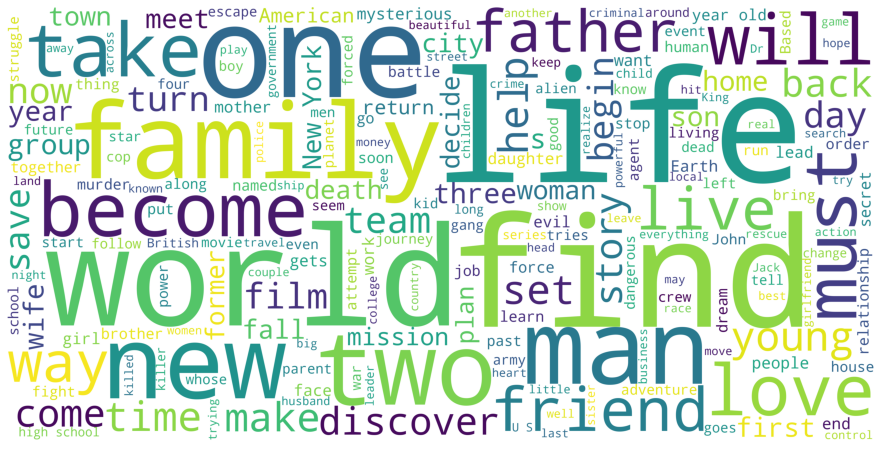

In [61]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

## Genres

In [62]:
genres_data = fd[fd['genres'] !='[]']
genres_data

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,return
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,11.763566
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,3.203333
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,3.594590
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,4.339756
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,1.092843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,"[{""id"": 35, ""name"": ""Comedy""}]",http://www.miramax.com/movie/clerks/,"[{""id"": 1361, ""name"": ""salesclerk""}, {""id"": 30...",en,Clerks,Convenience and video store clerks Dante and R...,19.748658,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-13,3151130,92.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Just because they serve you doesn't mean they ...,Clerks,7.4,755,116.708519
4788,12000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 35, ""nam...",NaN,"[{""id"": 237, ""name"": ""gay""}, {""id"": 900, ""name...",en,Pink Flamingos,Notorious Baltimore criminal and underground f...,4.553644,"[{""name"": ""Dreamland Productions"", ""id"": 407}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1972-03-12,6000000,93.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,An exercise in poor taste.,Pink Flamingos,6.2,110,500.000000
4792,20000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 27, ""name...",NaN

In [63]:
genres_data['genres'] = genres_data['genres'].fillna('[]').apply(ast.literal_eval)
genres_data['genres'] = genres_data['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [64]:
genres_s = genres_data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
genres_s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(genres_s)

In [65]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(20)

,genre,movies
0,Drama,1397
1,Comedy,1062
2,Thriller,915
3,Action,893
4,Adventure,653
5,Romance,553
6,Crime,508
7,Science Fiction,426
8,Family,353
9,Fantasy,335


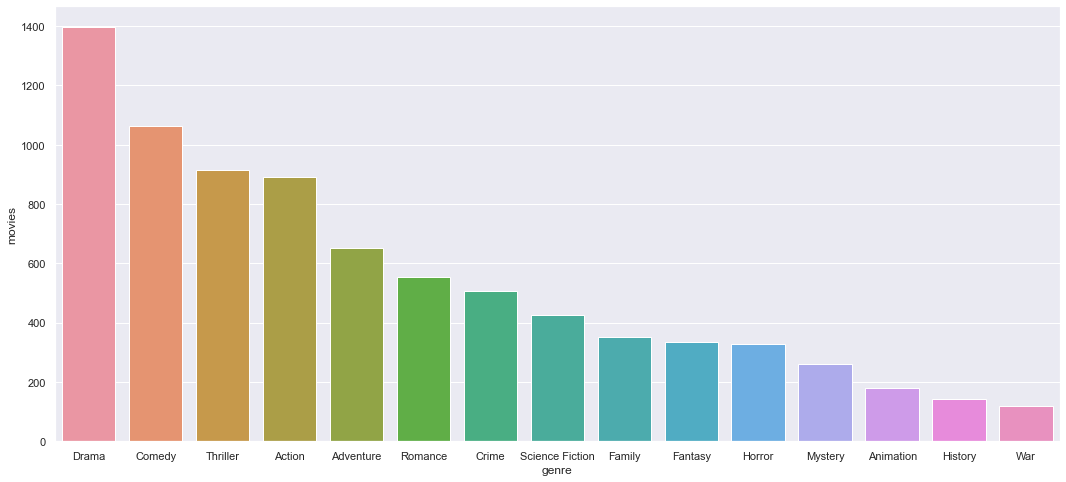

In [66]:
plt.figure(figsize=(18,8))
sb.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

## Revenue Study
Remove lower 10 percentile of budget and revenue

In [67]:
revenue_data = fd[fd['revenue'] > fd['revenue'].quantile(0.1)]

revenue_data

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,return
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,11.763566
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,3.203333
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,3.594590
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,4.339756
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,1.092843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,100000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.facingthegiants.com/,"[{""id"": 5950, ""name"": ""christian""}, {""id"": 607...",en,Facing the Giants,A losing coach with an underdog football team ...,4.563698,"[{""name"": ""Destination Films"", ""id"": 769}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-09-29,10178331,111.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Never give up. Never back down. Never lose faith.,Facing the Giants,6.6,64,101.783310
4723,100000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",http://thegallowsmovie.com/,"[{""id"": 2125, ""name"": ""gallows""}, {""id"": 6270,...",en,The Gallows,20 years after a horrific accident during a sm...,18.045782,"[{""name"": ""New Line Cinema"", ""id"": 12}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-07-10,42664410,87.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Every School Has Its Spirit,The Gallows,4.9,361,426.644100
4724,10000,"[{""id"": 18, ""name"": ""Dram

In [68]:
revenue_data['revenue'].describe()

count    2.818000e+03
mean     1.375609e+08
std      1.937202e+08
min      4.651977e+06
25%      2.741689e+07
50%      6.982901e+07
75%      1.629186e+08
max      2.787965e+09
Name: revenue, dtype: float64

In [69]:
revenue_data['revenue'].describe()

count    2.818000e+03
mean     1.375609e+08
std      1.937202e+08
min      4.651977e+06
25%      2.741689e+07
50%      6.982901e+07
75%      1.629186e+08
max      2.787965e+09
Name: revenue, dtype: float64

## Predicting Revenue using Budget
Plot Revenue against Budget using standard ScatterPlot/JointPlot.

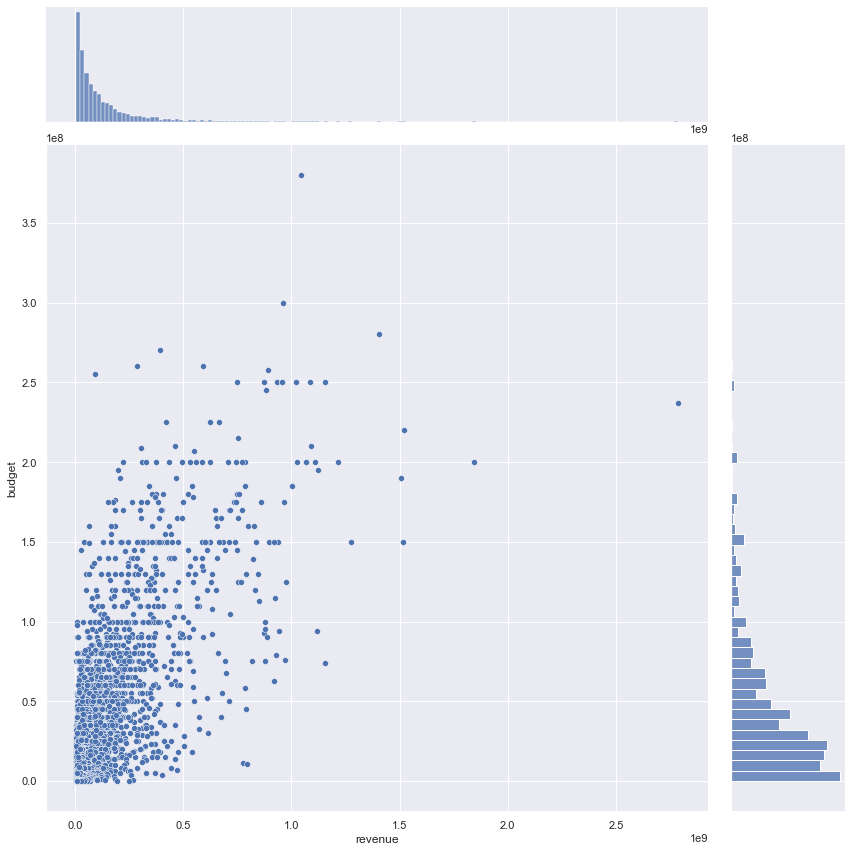

In [70]:
sb.jointplot(data = revenue_data, x = "revenue", y = "budget", height = 12)

In [71]:
print("Correlation Coefficient: ", revenue_data.revenue.corr(revenue_data.budget))

Correlation Coefficient:  0.6899295781511045


In [72]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
linreg = LinearRegression()
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(revenue_data['revenue'])
X = pd.DataFrame(revenue_data['budget'])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (2113, 1) (2113, 1)
Test Set  : (705, 1) (705, 1)


Fit Linear Regression model on the Training Dataset.

In [73]:
linreg.fit(X_train, y_train)

LinearRegression()

#### Visual Representation of the Linear Regression Model

Check the coefficients of the Linear Regression model you just fit.

In [74]:
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [5950040.19818833]
Coefficients 	: a =  [[2.96013861]]


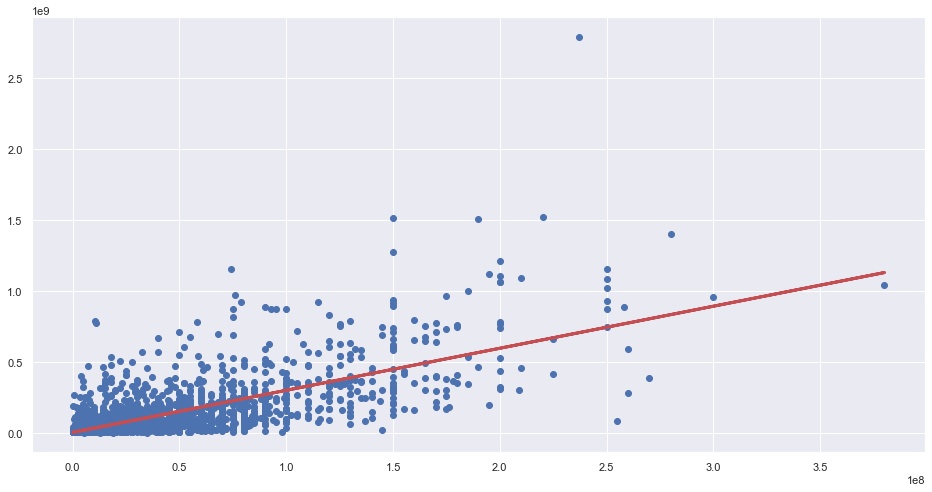

In [75]:
# Formula for the Regression line
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

# Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Train Set.

Metric: Explained Variance or R^2 on the Train Set.

Metric: Mean Squared Error (MSE) on the Train Set.

In [76]:
# Explained Variance in simply the "Score"
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

# Import the required metric from sklearn
from sklearn.metrics import mean_squared_error

# Predict the response on the train set
y_train_pred = linreg.predict(X_train)

# Compute MSE on the train set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Explained Variance (R^2) 	: 0.46992566436601946
Mean Squared Error (MSE) 	: 2.00887843105878e+16


# Prediction of Response based on the Predictor
Predict Revenue given Budget in the Test dataset.

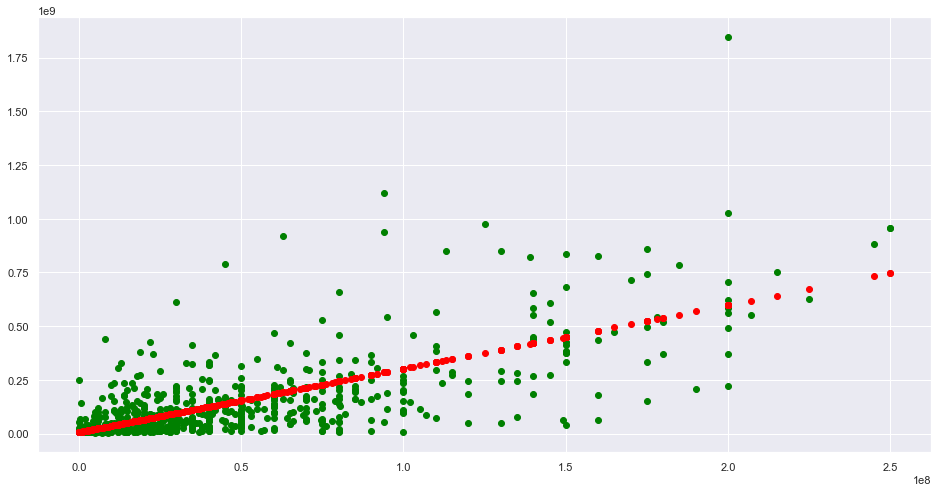

In [77]:
# Predict Revenue values corresponding to Budget
y_test_pred = linreg.predict(X_test)

# Plot the Predictions on a Scatterplot
f = plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, color = "green")
plt.scatter(X_test, y_test_pred, color = "red")
plt.show()

### Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Test Set.

Metric: Mean Squared Error (MSE) on the Test Set.

In [78]:
# Compute MSE on the test set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Mean Squared Error (MSE) 	: 1.837825874416834e+16


## Predicting Revenue using Popularity
Plot Revenue against Popularity using standard ScatterPlot/JointPlot.

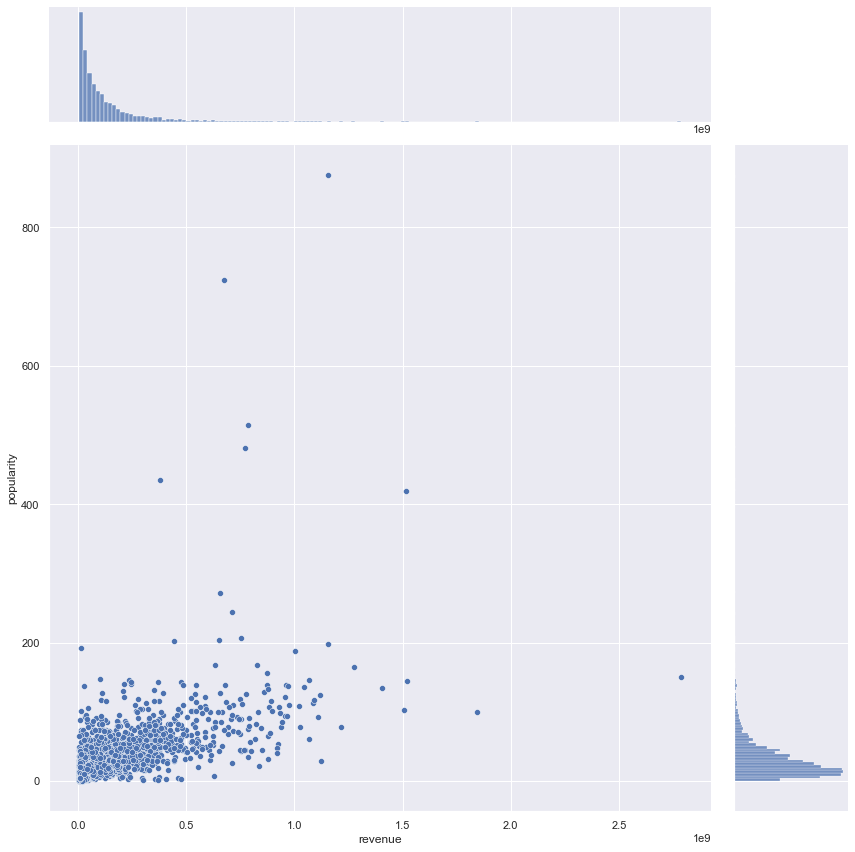

In [79]:
sb.jointplot(data = revenue_data, x = "revenue", y = "popularity", height = 12)

In [80]:
print("Correlation Coefficient: ", revenue_data.revenue.corr(revenue_data.popularity))

Correlation Coefficient:  0.5841437618981379


In [81]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
linreg = LinearRegression()
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(revenue_data['revenue'])
X = pd.DataFrame(revenue_data['popularity'])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (2113, 1) (2113, 1)
Test Set  : (705, 1) (705, 1)


Fit Linear Regression model on the Training Dataset.

In [82]:
linreg.fit(X_train, y_train)

LinearRegression()

In [83]:
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [43735092.8874317]
Coefficients 	: a =  [[3034603.48255308]]


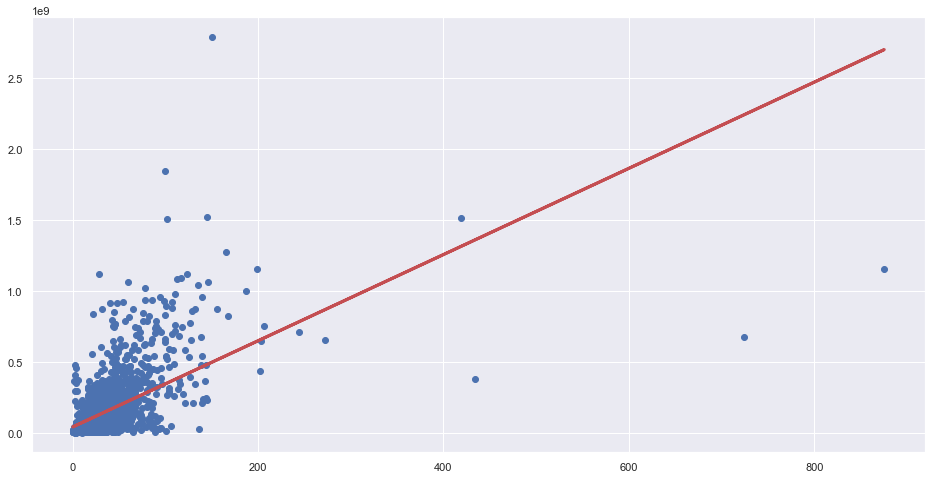

In [84]:
# Formula for the Regression line
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

# Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Train Set.

Metric: Explained Variance or R^2 on the Train Set.

Metric: Mean Squared Error (MSE) on the Train Set.

In [85]:
# Explained Variance in simply the "Score"
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

# Import the required metric from sklearn
from sklearn.metrics import mean_squared_error

# Predict the response on the train set
y_train_pred = linreg.predict(X_train)

# Compute MSE on the train set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Explained Variance (R^2) 	: 0.3399440985886998
Mean Squared Error (MSE) 	: 2.629433560002974e+16


# Prediction of Response based on the Predictor
Predict Revenue given Popularity in the Test dataset.

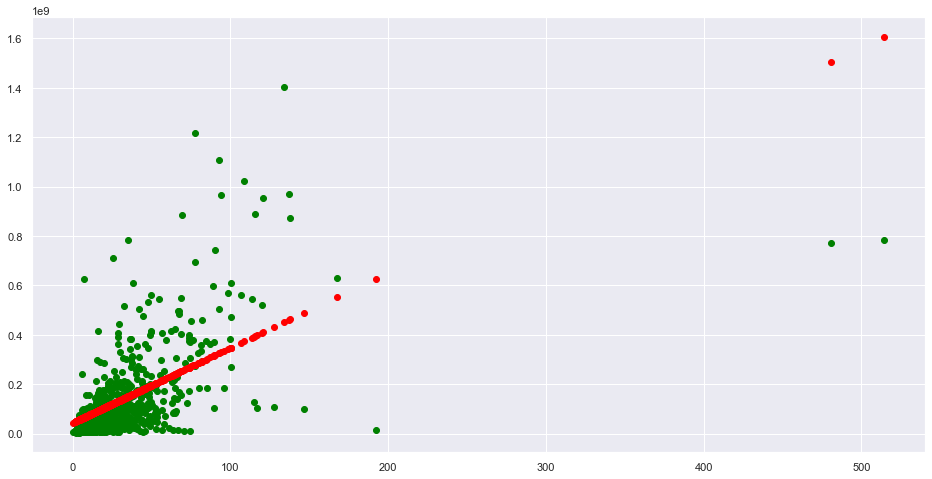

In [86]:
# Predict Revenue values corresponding to Popularity
y_test_pred = linreg.predict(X_test)

# Plot the Predictions on a Scatterplot
f = plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, color = "green")
plt.scatter(X_test, y_test_pred, color = "red")
plt.show()

### Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Test Set.

Metric: Mean Squared Error (MSE) on the Test Set.

In [87]:
# Compute MSE on the test set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Mean Squared Error (MSE) 	: 2.0018726066710236e+16


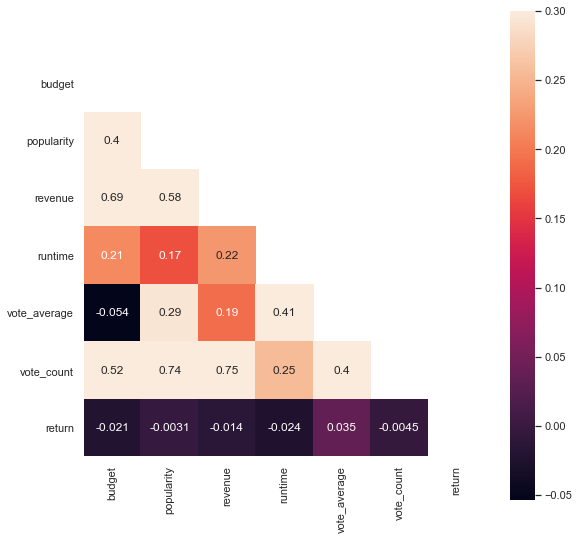

In [88]:
sb.set(font_scale=1)
corr = revenue_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sb.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

According to above map, most suitable predictors for revenue are vote_count(0.75) > budget(0.69) > popularity(0.58)

## Predicting Revenue using Genres

Following genres cover most of the movie, we would like to find out which genres will be most profitable.

In [91]:
pop_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
pop_movies = gen_df[(gen_df['genre'].isin(pop_genres))]

<Figure size 1296x864 with 0 Axes>

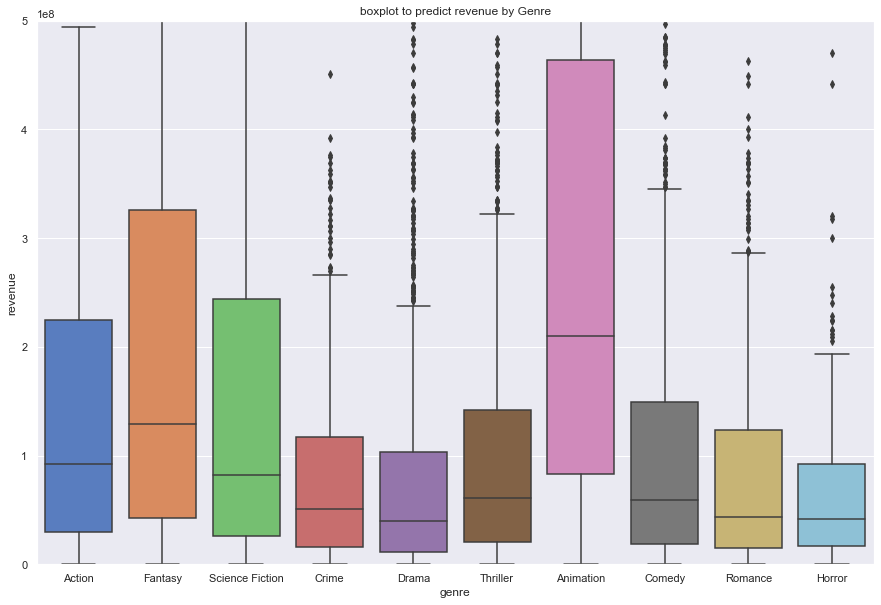

In [93]:
plt.figure(figsize=(18,12))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 10))
sb.boxplot(x='genre', y='revenue', data=pop_movies, palette="muted", ax =ax)
ax.set_ylim([0, 5e8])
plt.title("boxplot to predict revenue by Genre")
plt.show()

From above box plot, Animation produce the highest Median among other genres. Also, it prodeces the largeest Interquartile Range(IQR)

## Predicting Return using Genres